##Install and import required packages

In [1]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.8 MB/s eta 0:00:00


In [3]:
pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
import colorama 
from colorama import Fore, Style, Back
import random
import nlpaug.augmenter.word as naw
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Concatenate, Dot, Activation, Flatten, TimeDistributed, GRU
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from textblob import TextBlob
import google.auth
from google.colab import auth
from googleapiclient.discovery import build
from google.oauth2 import service_account
from statistics import mean

##Data import and preprocessing

In [5]:
with open('intents.json') as file:
    data = json.load(file)
    
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)
print(len(training_sentences))
print(training_labels)

309
['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'morning', 'morning', 'afternoon', 'afternoon', 'evening', 'evening', 'night', 'night', 'night', 'night', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'no-response', 'neutral-response', 'neutral-response', 'neutral-response', 'neutral-response', 'neutral-response', 'neutral-response', 'neutral-response', 'neutral-response', 'about', 'about', 'about', 'about', 'about', 'about', 'about', 'about', 'skill', 'skill', 'creation', 'creation', 'creation', 'name', 'name', 'name', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'help', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'stressed', 'stressed', 'stressed', 'stressed', 'stressed', 'worthless', 'worthless', 'worthless', 'worthless',

In [6]:
# Initialize augmentation object
aug = naw.SynonymAug(aug_src='wordnet')

# Augment sentences
aug_sentences = []
for sentence in training_sentences:
    aug_sentence = aug.augment(sentence)
    aug_sentences.append(aug_sentence)
    
# Print augmented sentences
#print(aug_sentences)
#print(training_labels)

#expand the training sentences and the labels to enlarge the dataset
training_sentences.extend(aug_sentences)
training_labels.extend(training_labels)

print(len(training_sentences))
print(len(training_labels))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


618
618


In [7]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [8]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

##RNN MODEL

In [9]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(4, recurrent_dropout=0.2,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(4, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(2, recurrent_dropout=0.3, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['CategoricalAccuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 20, 8)            672       
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 8)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 8)            416       
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 20, 8)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 4)            1

In [ ]:
from keras.utils import to_categorical

one_hot_labels = to_categorical(training_labels, num_classes)
#print(one_hot_labels.shape)
print(training_labels)

In [10]:
epochs = 50
history = model.fit(padded_sequences, training_labels, epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/50
18/18 [==============================] - 15s 141ms/step - loss: 4.5041 - categorical_accuracy: 0.0018 - val_loss: 4.5263 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 1s 45ms/step - loss: 4.3995 - categorical_accuracy: 0.0000e+00 - val_loss: 4.7346 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 1s 46ms/step - loss: 4.2079 - categorical_accuracy: 0.0000e+00 - val_loss: 5.3418 - val_categorical_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 1s 46ms/step - loss: 4.1783 - categorical_accuracy: 0.0054 - val_loss: 5.4226 - val_categorical_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 1s 45ms/step - loss: 4.1398 - categorical_accuracy: 0.0018 - val_loss: 5.3576 - val_categorical_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 1s 46ms/step - loss: 4.1127 - categorical_accuracy: 0.0000e+00 - val_loss: 5.4483 - val_categ

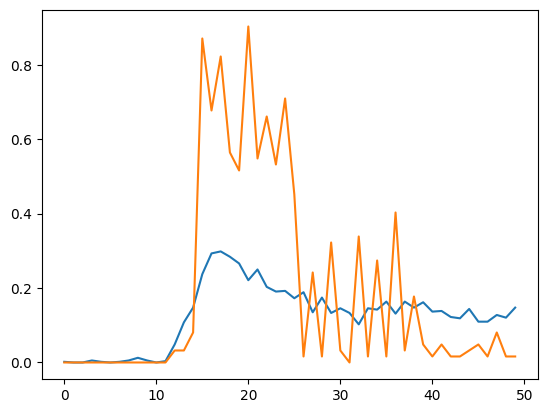

In [11]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

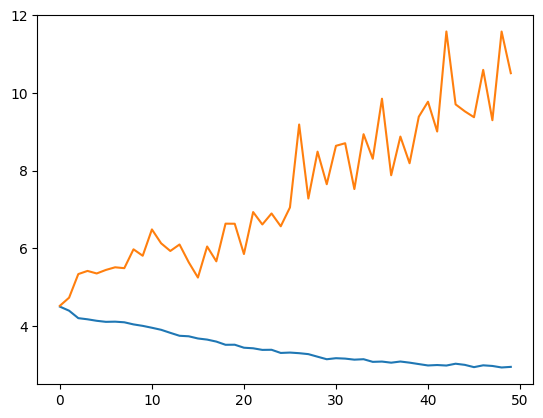

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

##Model save and export

In [13]:
# to save the trained model
model.save("chat_model")

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

##Chat script 

In [14]:
with open("intents.json") as file:
    data = json.load(file)

input_list = []

def chat(input_list):
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        input_list.append(inp)
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        #print(result)                                    
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        print(tag)
        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))
    return input_list

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
total_input = chat(input_list)

print(len(total_input))

Start messaging with the bot (type quit to stop)!
User: Hey
1/1 [==============================] - 3s 3s/step
['greeting']
ChatBot: Hello there. Tell me how are you feeling today?
User: I'm feeling great
1/1 [==============================] - 0s 28ms/step
['greeting']
ChatBot: Hi there. What brings you here today?
User: I'm having a great day
1/1 [==============================] - 0s 28ms/step
['about']
ChatBot: You can call me Digital Friend.
User: Call me Chris
1/1 [==============================] - 0s 28ms/step
['neutral-response']
ChatBot: Is something on your mind?
User: I'm so happy today
1/1 [==============================] - 0s 27ms/step
['greeting']
ChatBot: Hello there. Glad to see you're back. What's going on in your world right now?
User: Okay now you're starting to bother me
1/1 [==============================] - 0s 30ms/step
['about']
ChatBot: You can call me Digital Friend.
User: I hate you
1/1 [==============================] - 0s 27ms/step
['about']
ChatBot: You can ca

##Chat results and metrics

In [15]:
first_five_inputs = total_input[0:5]
last_five_inputs =  total_input[-5:]

first_five_sentiments = []
last_five_sentiments = []

for input in first_five_inputs:
  first_five_sentiments.append(TextBlob(input).sentiment.polarity)

for input in last_five_inputs:
  last_five_sentiments.append(TextBlob(input).sentiment.polarity)

first_five_sum = 0
last_five_sum = 0

for polarity in first_five_sentiments:
  first_five_sum = first_five_sum + polarity

for polarity in last_five_sentiments:
  last_five_sum = last_five_sum + polarity

if first_five_sum < last_five_sum:
  print("There was an improvement in sentiment throughout the chat process")

if first_five_sum > last_five_sum:
  print("There was a decline in sentiment throughout the chat process")

if first_five_sum == last_five_sum:
  print("There was no change in sentiment throughout the chat process")

There was a decline in sentiment throughout the chat process


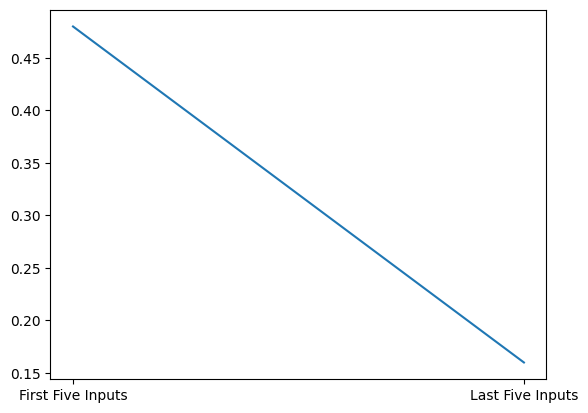

In [16]:
sentiment_means = [mean(first_five_sentiments), mean(last_five_sentiments)]
names = ["First Five Inputs", 'Last Five Inputs']

plt.plot(names, sentiment_means)
plt.show()

##Post-Chat survey

https://docs.google.com/forms/d/e/1FAIpQLSfeZG2RkqeHAdvU4jIJCBBdl0y0_yQGOwaR-WpPx5GQwCap3w/viewform